In [ ]:
"""Implementing Anze's proposal of doing a normal gaussian fit as the test case (theory points)
for time offset, new metric is (data point - theory point)**2 summed for all data points
in all four dishes, normalized to account for trimmed data"""

In [500]:
#importing requisite modules
import statistics
import pickle
import numpy as np
from scipy.special import jv
import matplotlib.pyplot as plt
import scipy.optimize as opt
from astropy.modeling import models, fitting
import copy
import scipy.interpolate as interp
import scipy.ndimage
from astropy.table import Table, Column
from astropy.io import ascii as askee

In [2]:
#reading in allFLYs data
with open('../Data/allFLYs.pkl', 'rb') as pickle_file:
    allFLYs = pickle.load(pickle_file, encoding = 'latin1')

In [3]:
#defining gaussian fitting function
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    g = offset + amplitude * np.exp(-(((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    return g.ravel()

In [4]:
#defining a function that gives the range of a dataset
def span(data):
    return (max(data)-min(data))

In [5]:
def get_data(flight, freq_index):
    #getting signal and location data for specific flight
    flyData = []
    for i in range(len(allFLYs)):
        if allFLYs[i]['FLY']==flight:
            flyData = allFLYs[i]
            
    #checking if the flight data was obtained properly
    if len(flyData)==0:
        print('No flight with that number! Please enter one of the following for the flight argument: 340, 342, 343, 344, 347, 349, 351, 352, 353')
        return
    
    signal_array = np.empty((len(flyData['autos']), len(flyData['x'])), dtype = 'float')
    
    for i in range(len(flyData['autos'])):
        signal_array[i] = flyData['autos'][i][:,freq_index]
    
    thetaX_array = flyData['thetaX']
    thetaY_array = flyData['thetaY']
    
    return signal_array, thetaX_array, thetaY_array  

In [6]:
#getting boundaries for the gaussian fits
def get_boundaries(xdata, ydata):
    bounds = np.empty(4, dtype = object)
    for i in range(len(xdata)):
        lowerbounds = [-np.inf, min(xdata[i]), min(ydata[i]), -np.inf, -np.inf, -np.inf]
        upperbounds = [np.inf, max(xdata[i]), max(ydata[i]), span(xdata[i]), span(ydata[i]), np.inf]
        bounds[i] = (lowerbounds, upperbounds)
    
    return bounds

In [7]:
#getting initial guesses for the gaussian fits
def get_initial_guesses(signal, xdata, ydata):
    guesses = [[],[],[],[]]
    
    for i in range(len(signal)):
        maxindex = np.where(signal[i] == max(signal[i]))
        guesses[i] = (max(signal[i]), xdata[i][maxindex], ydata[i][maxindex], 0.05, 0.05, 0)
        
    guesses = np.array(guesses, dtype = 'float64')
    return guesses

In [19]:
#calculates a 2d gaussian and uncertainty for each dish
def calculate_gaussians(signal, xdata, ydata, guesses, bounds):
    gaussians = np.empty(4, dtype = object)
    covariance = np.empty(4, dtype = object)
    errors = np.empty(4, dtype = object)
    
    for i in range(len(signal)):
        gaussians[i], covariance[i] = opt.curve_fit(twoD_Gaussian, (xdata[i], ydata[i]), signal[i], p0 = guesses[i]
                                                  , maxfev = 100000, method = 'dogbox', bounds = bounds[i])
        errors[i] = np.sqrt(np.diag(covariance[i]))
    
    return gaussians, errors

In [20]:
#calculates gaussians in the event that the original fit was catastrophic, resulting in a bad fit
#uses method = lm, no bounds this time.
#anecdotally this seems to be a more reliable method, but takes longer
#and doesn't produce a covariance matrix

def backup_gaussians(signal, xdata, ydata, guesses, original_gaussians):
    gaussians = np.empty(4, dtype = object)
    for i in range(len(signal)):
        try:
            gaussians[i], discard = opt.curve_fit(twoD_Gaussian, (xdata[i], ydata[i]), signal[i], p0 = guesses[i]
                                                  , maxfev = 10000)
        except:
            gaussians[i] = original_gaussians[i]
    return gaussians

In [21]:
#for iterative purposes, the offsets start out as just a list of indices
#this gets the conversion factor to turn those indices into times
#by getting the range of mjd, turning it into seconds, and dividing it by the number of indices

def get_conversion_factor(flight):
    flyData = []
    for i in range(len(allFLYs)):
        if allFLYs[i]['FLY']==flight:
            flyData = allFLYs[i]
            
    #checking if the flight data was obtained properly
    if len(flyData)==0:
        print('No flight with that number! Please enter one of the following for the flight argument: 340, 342, 343, 344, 347, 349, 351, 352, 353')
        return
    
    duration = span(flyData['mjdB'])*86400 #range of mjd, converted to seconds
    time_per_index = duration/len(flyData['x'])
    
    return time_per_index
    

In [22]:
#calculating a goodness of fit metric
#sum of squared residual b/w signal and modeled signal at same (x,y) coord
#summed across all 4 dishes
#normalized by the number of data points used

def calculate_goodness_of_fit(signal, xdata, ydata, mod):
    residual_sum = 0.0
    for i in range(len(signal)):
        residual_sum += np.sum((signal[i]-mod[i](xdata[i], ydata[i]))**2)    
    goodness_of_fit_metric = residual_sum/len(signal[0])
    
    return goodness_of_fit_metric

In [23]:
#actually performing the time offset calculation

def time_offset_calculator(signal, xdata, ydata, offset_limit, mod, index_to_seconds):
    #prepping output: time range and fit metrics
    offset_array = np.arange(-offset_limit, offset_limit)
    goodness_of_fit = np.zeros(len(offset_array))
    
    #trying all time indices
    for i in range(len(offset_array)):
        #preallocating temporary data objects
        tempSig = np.empty(4, dtype = object)
        tempX = np.empty(4, dtype = object)
        tempY = np.empty(4, dtype = object)
        
        #trimming signal and location data at opposite ends to simulate a time offset
        if offset_array[i] < 0:
            for j in range(len(tempSig)):
                tempSig[j] = signal[j][np.abs(offset_array[i]):]
                tempX[j] = xdata[j][:(len(xdata[j])-np.abs(offset_array[i]))]
                tempY[j] = ydata[j][:(len(ydata[j])-np.abs(offset_array[i]))]
        elif offset_array[i] > 0:
            for j in range(len(tempSig)):
                tempSig[j] = signal[j][:(len(signal[j])-np.abs(offset_array[i]))]
                tempX[j] = xdata[j][np.abs(offset_array[i]):]
                tempY[j] = ydata[j][np.abs(offset_array[i]):]
        else:
            tempSig = copy.deepcopy(signal)
            tempX = copy.deepcopy(xdata)
            tempY = copy.deepcopy(ydata)
        
        #calculating metric
        goodness_of_fit[i] = calculate_goodness_of_fit(tempSig, tempX, tempY, mod)
        
    #converting indices to time
    offset_array = offset_array * index_to_seconds
    return goodness_of_fit, offset_array

In [486]:
# time offset calculator
# realigns the signal and location data within some limits
# performs airy disk fits, and minimizes the residual w/ the test case

def find_time_offset_airy(flight, freq_index, offset_limit):
    
    #getting data to fit
    signal_array, thetaX_array, thetaY_array = get_data(flight, freq_index)
    
    #getting conversion factor to turn the offset array into seconds, rather than array indices
    index_to_seconds = get_conversion_factor(flight)
    
    #calculating airy disk fitsto compare the time-adjusted data to
    
    fitter = fitting.LevMarLSQFitter()
    test_models = np.empty(4, dtype = object)
    for i in range(len(gaussians)):
        amp = max(signal_array[i])
        xmean = thetaX_array[i][np.where(signal_array[i] == max(signal_array[i]))]
        ymean = thetaY_array[i][np.where(signal_array[i] == max(signal_array[i]))]  
        initial_guess = models.AiryDisk2D(amp, xmean, ymean, 0.1) 
        test_models[i] = fitter(initial_guess, thetaX_array, thetaY_array, signal_array)
    
    #finding first pass time offsets
    fits, times = time_offset_calculator(signal_array, thetaX_array, thetaY_array, offset_limit, test_models
                                        , index_to_seconds)
    
    return fits, times
    

In [487]:
# time offset calculator
# realigns the signal and location data within some limits
# performs gaussian fits, and minimizes the residual w/ the test case

def find_time_offset_gauss(flight, freq_index, offset_limit):
    
    #getting data to fit
    signal_array, thetaX_array, thetaY_array = get_data(flight, freq_index)
    
    #getting conversion factor to turn the offset array into seconds, rather than array indices
    index_to_seconds = get_conversion_factor(flight)
    
    #calculating gaussian fits to compare the time-adjusted data to
    boundaries = get_boundaries(thetaX_array, thetaY_array)
    initial_guesses = get_initial_guesses(signal_array, thetaX_array, thetaY_array)   
    gaussians, errors = calculate_gaussians(signal_array, thetaX_array, thetaY_array, initial_guesses, boundaries)
    test_models = []
    for i in range(len(gaussians)):
        test_models.append(models.Gaussian2D(gaussians[i][0], gaussians[i][1], gaussians[i][2], gaussians[i][3]
                                             , gaussians[i][4], 0))
    
    #finding first pass time offsets
    fits, times = time_offset_calculator(signal_array, thetaX_array, thetaY_array, offset_limit, test_models
                                        , index_to_seconds)
    
    #based on previous tests, no reasonable time offset >0.6
    #limit below is 1.2 s, so anything >1 is catastrophic
    if np.abs(times[np.where(fits==min(fits))]) > 1:
        gaussians = backup_gaussians(signal_array, thetaX_array, thetaY_array, initial_guesses, gaussians)
        test_models = []
        for i in range(len(gaussians)):
            test_models.append(models.Gaussian2D(gaussians[i][0], gaussians[i][1], gaussians[i][2], gaussians[i][3]
                                                 , gaussians[i][4], 0))
        #take two on finding time offsets with slightly different gaussian parameters
        #in the even that the first try failed (got >1)
        fits, times = time_offset_calculator(signal_array, thetaX_array, thetaY_array, offset_limit
                                             , test_models, index_to_seconds)
    
    return fits, times, errors
    

In [62]:
#using the plethora of functions defined above to find the best fit time offsets
#for all flights at all frequencies between 1150 and 1520 MHz
#using a gaussian model

flightnames = []
freqmin = 23 #defining the frequency range, roughly 1150 - 1520 MHz
freqmax = 196

#getting the flight names
for i in range(len(allFLYs)):
    if allFLYs[i]['FLY'] != '353': #flight 353 has garbage data, disregarding
        flightnames.append(allFLYs[i]['FLY'])

#preallocation 
time_offsets_v2 = np.empty((len(flightnames), freqmax-freqmin), dtype = 'float')
error_array = np.empty((len(flightnames), freqmax-freqmin), dtype = 'object')
goodness_of_fit = np.empty((len(flightnames), freqmax-freqmin), dtype = 'object')

#running the time offsets calculator for all flights, all frequency channels in range
for i in range(len(flightnames)):
    for freq_index in range(freqmin,freqmax):
        fits, times, errors = find_time_offset_gauss(flightnames[i], freq_index, 40)
        error_array[i][freq_index-freqmin] = errors
        goodness_of_fit[i][freq_index-freqmin] = fits
        time_offsets_v2[i][freq_index-freqmin] = times[np.where(fits==min(fits))]

/astro/u/gtroiani/.conda/envs/mypy/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [488]:
#using the plethora of functions defined above to find the best fit time offsets
#for all flights at all frequencies between 1150 and 1520 MHz
#using an airy disk model

flightnames = []
freqmin = 23 #defining the frequency range, roughly 1150 - 1520 MHz
freqmax = 196

#getting the flight names
for i in range(len(allFLYs)):
    if allFLYs[i]['FLY'] != '353': #flight 353 has garbage data, disregarding
        flightnames.append(allFLYs[i]['FLY'])

#preallocation 
time_offsets_airy = np.empty((len(flightnames), freqmax-freqmin), dtype = 'float')
GoF_airy = np.empty((len(flightnames), freqmax-freqmin), dtype = 'object')

#running the time offsets calculator for all flights, all frequency channels in range
for i in range(len(flightnames)):
    for freq_index in range(freqmin,freqmax):
        fits, times = find_time_offset_airy(flightnames[i], freq_index, 40)

        GoF_airy[i][freq_index-freqmin] = fits
        time_offsets_airy[i][freq_index-freqmin] = times[np.where(fits==min(fits))]

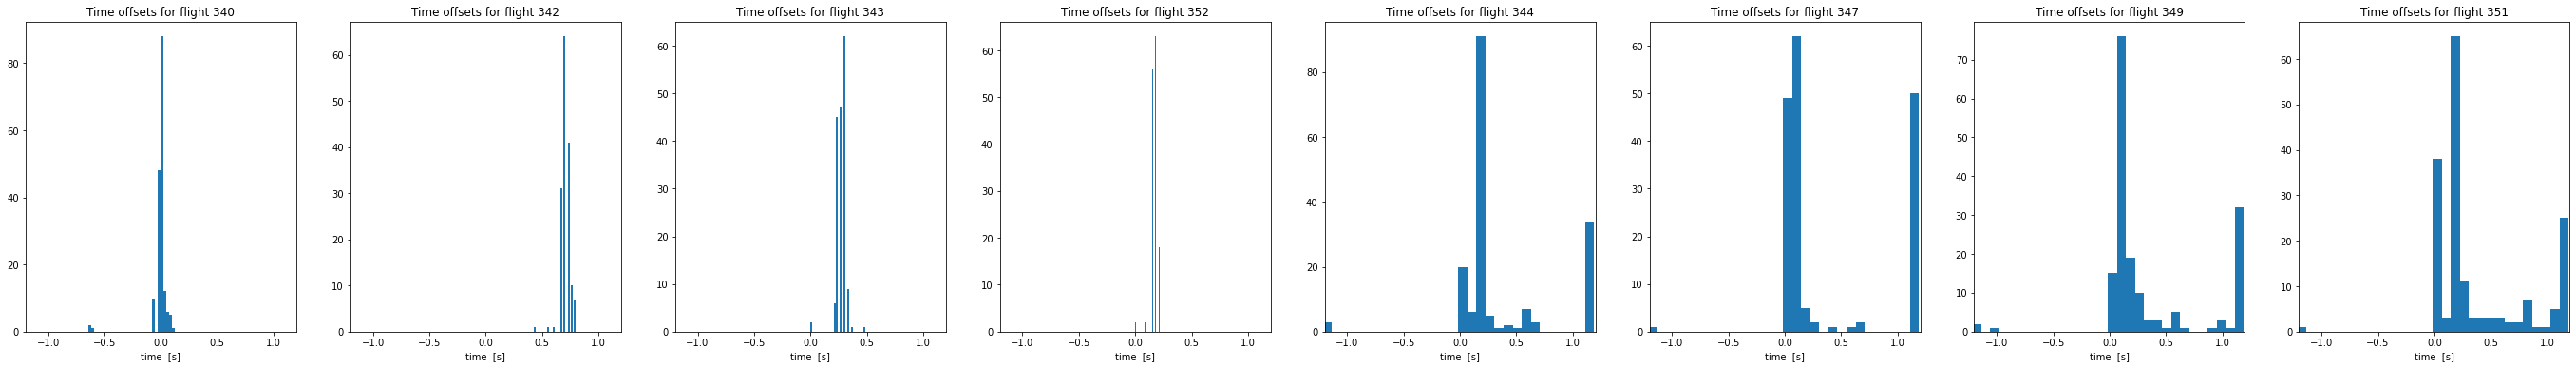

In [493]:
#Plotting histograms of time offsets; peak should be the actual time offset

fig, axs = plt.subplots(nrows = 1, ncols = len(flightnames), figsize = (6*len(flightnames), 6))

for i in range(len(flightnames)):
    axs[i].hist(time_offsets_airy[i], bins = 30)
    axs[i].set_title('Time offsets for flight ' + flightnames[i])
    axs[i].set_xlabel('time  [s]')
    axs[i].set_xlim(-1.2,1.2) #uncomment this line to restric
plt.savefig('TimeOffsetsAiry.png')

In [65]:
#manually creating table of flights and time offsets
#the output of this was manually put into a .csv for later use
#and is also used to apply time shifts later in this file
mode = np.zeros(len(flightnames))
for i in range(len(time_offsets_v2)):
    mode[i] = statistics.mode(time_offsets_v2[i])
    print(flightnames[i], mode[i])

340 0.396544032541686
342 0.5490622689628577
343 0.3050352979291777
352 0.12201344080385369
344 0.12201314290824554
347 0.12201352719605717
349 0.09150993577757235
351 0.18302011317557673


In [498]:
airy_time_offsets = Table(names = ('flight', 'offset_airy', 'offset_gauss')
                          , dtype = ['str', 'float', 'float'])
for i in range(len(flightnames)):
    next_row = [flightnames[i], statistics.mode(time_offsets_airy[i]), mode[i]]
    airy_time_offsets.add_row(next_row)
askee.write(airy_time_offsets, 'offsets_airyVgauss.csv', format = 'csv', fast_writer=False)

In [497]:
airy_time_offsets['offset_airy']

<Table length=8>
flight     offset_airy         offset_gauss   
 str3        float64             float64      
------ ------------------- -------------------
   340                 0.0   0.396544032541686
   342  0.7015795658969849  0.5490622689628577
   343  0.3050352979291777  0.3050352979291777
   352 0.18302016120578055 0.12201344080385369
   344 0.15251642863530693 0.12201314290824554
   347  1.1896318901615575 0.12201352719605717
   349 0.09150993577757235 0.09150993577757235
   351 0.15251676097964728 0.18302011317557673

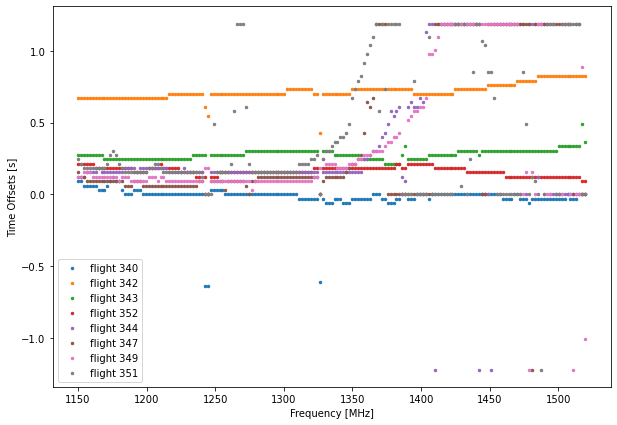

In [499]:
#creating plots of freq vs time offset for each flight
freqs = np.zeros(len(time_offsets_airy[0]))
for i in range(len(time_offsets_airy[0])):
    freqs[i] = 1150 + i * 2.1484375

fig = plt.figure(figsize= (10,7))
for j in range(len(flightnames)):
    if flightnames[j] != '353':
        plt.scatter(freqs, time_offsets_airy[j], s=6, label = 'flight ' +flightnames[j])
        plt.legend()
        plt.ylabel('Time Offsets [s]')
        plt.xlabel('Frequency [MHz]')
 #       plt.ylim(-1,1) #uncomment this line to get rid of the failed runs

plt.savefig('airytimeoffsets_vs_freq.png')

In [73]:
#all flights have roughly 30 ms sampling for the location and signal data
#finding the flight with the most precise conversion factor between
#index and time. 

flight = ''
conversionfactor = 0
maxlen = 0
for i in range(len(allFLYs)):
    if allFLYs[i]['FLY'] != '353': #flight 353 is garbage
        if len(allFLYs[i]['x']) > maxlen: #finding the longest flight to get the most precise timestep
            maxlen = len(allFLYs[i]['x'])
            conversionfactor = (span(allFLYs[i]['mjdB'])*86400)/maxlen

most accurate conversion factor is from flight 343 at 0.030503529792917775


In [123]:
"""For each flight make a plot of the pointing centers of the 4 dishes vs 
frequency, like the one on slide 4 of BMXmtg_200427.pptx.
Use the offset you chose from your time offset optimization. 
Only include frequencies where the goodness-of-fit parameter was reasonable."""

#Setting limits for the frequency bin, determined by the graph of
#time offsets vs frequency (see above code)
#which showed that for most flights the time offsets were most
#stable between 1250 and 1350 MHz

freqbin_min = 70 #index of 1250 MHz
freqbin_max = 117 #index of 1350 MHz
flight_index = 0 #needed index and flight name, keeping track if index separately

#preallocation of guassian fits and errors
gauss = np.empty(len(flightnames), dtype = object)
err = np.empty(len(flightnames), dtype = object)

#performing operation for all flights
for flight in flightnames:
    #preallocating temporary gaussians fits and errors
    gaussflight = np.empty((freqbin_max-freqbin_min), dtype = object)
    errflight = np.empty((freqbin_max-freqbin_min), dtype = object)
    for freq_index in range(freqbin_min, freqbin_max):
        #getting data
        signal, xdata, ydata = get_data(flight, freq_index)
        #converting back from offset to index
        offset_index = np.int(np.round(mode[flight_index]/conversionfactor))
        
        
        tempSig = np.empty(4, dtype = object)
        tempX = np.empty(4, dtype = object)
        tempY = np.empty(4, dtype = object)
        #applying time offset by shifting trimming the signal data at the end
        #and the location data at the beginning
        #by the amount specified by the offset index
        for j in range(len(tempSig)):
            tempSig[j] = signal[j][:(len(signal[j])-offset_index)]
            tempX[j] = xdata[j][offset_index:]
            tempY[j] = ydata[j][offset_index:]
        
        #calculating gaussians for the time-shifted data
        boundaries = get_boundaries(tempX, tempY)
        initial_guesses = get_initial_guesses(tempSig, tempX, tempY)
        gaussians, errors = calculate_gaussians(tempSig, tempX, tempY, initial_guesses, boundaries)
        
        #populating gaussian fit arrays for this flight
        gaussflight[freq_index-freqbin_min] = gaussians
        errflight[freq_index-freqbin_min] = errors
    
    #populating gaussian fit arrays with the fits from this flight
    gauss[flight_index] = gaussflight
    err[flight_index] = errflight
    flight_index += 1 #increasing the iterator

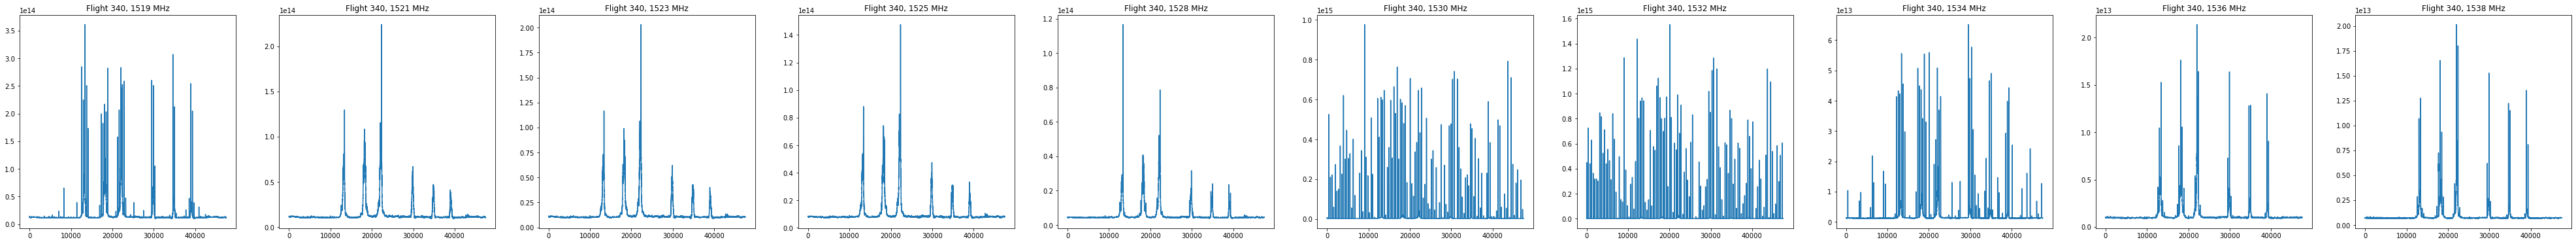

In [295]:
#just an aside that I played with to try and visualize why flight 347 was doing poorly
#in doing so found an anomoly in the data
#for all flights, between 1530 and 1534 MHz, drone signal is washed out by noise
#all flights implies that it continuous. 

fig, axs = plt.subplots(nrows = 1, ncols = 10, figsize = (70, 6))
for i in range(10):
    axs[i].set_title('Flight 340, '+str(np.int(np.round(1100 + (i+195) * 2.1484375)))+' MHz')
    sig, xdata, ydata = get_data('340', i+195)
    x = np.arange(0,len(sig[0]))
    axs[i].plot(x,sig[0])
 #   axs[i].plot([0,len(sig[0])], [min(sig[0]), min(sig[0])])
 #   center = np.sum(sig[0] * x)/np.sum(sig[0])
 #   axs[i].plot([center, center], [min(sig[0]), max(sig[0])])
#plt.savefig('FLY340_ndishsig_freqs.png')

In [124]:
offset_search_params = Table(names = ('Flight','Dish','Frequency','Optimized_Time_Offset','GoF_at_Opt'
                                      ,'Individual_Time_Offset','amp', 'amp_err','x0'
                                      ,'x0_err', 'y0', 'y0_err','x_sigma','x_sigma_err','y_sigma'
                                      ,'y_sigma_err','offset','offset_err')
                             ,dtype = ['str','str','int','float','float','float','float','float'
                                       ,'float','float','float','float','float','float','float'
                                       ,'float','float','float'])

dishes = ['N','E','S','W']
freq = np.zeros(len(gauss[0]))
for i in range(len(freq)):
    freq[i] = np.int(np.round((1100 +(freqbin_min+i)*2.1484375)))

for i in range(len(gauss)): #iterating over all flights
    for j in range(len(gauss[i])): #iterating over all frequencies
        for k in range(len(gauss[i][j])): #iterating over all dishes
            nextrow = [flightnames[i],dishes[k],freq[j],mode[i],min(goodness_of_fit[i][j])
                       ,time_offsets_v2[i][j+(freqbin_min-freqmin)],gauss[i][j][k][0],err[i][j][k][0]
                       ,gauss[i][j][k][1],err[i][j][k][1],gauss[i][j][k][2],err[i][j][k][2]
                       ,gauss[i][j][k][3],err[i][j][k][3],gauss[i][j][k][4],err[i][j][k][4]
                       ,gauss[i][j][k][5],err[i][j][k][5]]
            offset_search_params.add_row(nextrow)

askee.write(offset_search_params, 'time_offset_search_parameters.csv', format = 'csv', fast_writer=False)

In [125]:
offset_search_params #viewing the table just to make sure everything worked

<Table length=1504>
Flight Dish Frequency ...         offset               offset_err     
 str3  str1   int64   ...        float64                float64       
------ ---- --------- ... ---------------------- ---------------------
   340    N      1250 ...                    0.0                   0.0
   340    E      1250 ...                    0.0                   0.0
   340    S      1250 ...                    0.0                   0.0
   340    W      1250 ...                    0.0                   0.0
   340    N      1253 ...                    0.0                   0.0
   340    E      1253 ...                    0.0                   0.0
   340    S      1253 ...                    0.0                   0.0
   340    W      1253 ...                    0.0                   0.0
   340    N      1255 ...                    0.0                   0.0
   340    E      1255 ...                    0.0                   0.0
   ...  ...       ... ...                    ...                   ...
   351    S      1345 ...                    0.0                   0.0
   351    W      1345 ... -6.303473701247893e-11                   0.0
   351    N      1347 ...                    0.0                   0.0
   351    E      1347 ...                    0.0                   0.0
   351    S      1347 ...                    0.0                   0.0
   351    W      1347 ...  8.203198679113871e-10                   0.0
   351    N      1349 ...      42897738113464.82 5.235287222127426e-14
   351    E      1349 ...                    0.0                   0.0
   351    S      1349 ...                    0.0                   0.0
   351    W      1349 ...   8.04750075492309e-09                   0.0

In [530]:
airy_params = Table(names = ('Flight','Dish','Frequency', 'Individual_time_offset', 'GoF_param'
                             , 'Mode_Time_offset' ,'amp', 'x0', 'y0', 'radius')
                             ,dtype = ['str','str','int','float','float','float','float','float'
                                       ,'float','float'])
dishes = ['N','E','S','W']
freq = np.zeros(len(airy_array[0][0]))
for i in range(len(freq)):
    freq[i] = np.int(np.round((1100 +(freqbin_min+i)*2.1484375)))

for i in range(len(airy_array)): #iterating over all flights
    for j in range(len(airy_array[i])): #iterating over all dishes
        for k in range(len(airy_array[i][j])): #iterating over all frequencies
            nextrow = [flightnames[i],dishes[j],freq[k],time_offsets_airy[i][k+(freqbin_min-freqmin)]
                       ,min(GoF_airy[i][k]),airy_time_offsets['offset_airy'][i],airy_array[i][j][k][0]
                       ,airy_array[i][j][k][1],airy_array[i][j][k][2],airy_array[i][j][k][3]]
            airy_params.add_row(nextrow)

askee.write(airy_params, 'time_offset_search_parameters_airy.csv', format = 'csv', fast_writer=False)

In [531]:
airy_params

<Table length=1504>
Flight Dish Frequency ...           y0                  radius      
 str3  str1   int64   ...        float64               float64      
------ ---- --------- ... ---------------------- -------------------
   340    N      1250 ...   0.022877083998355797  0.0993731128546155
   340    N      1253 ...    0.02285405996728177 0.09922791664476713
   340    N      1255 ...    0.02289071145788448 0.09893932461335218
   340    N      1257 ...    0.02295987555440385 0.09843091921330213
   340    N      1259 ...   0.022973944827304818 0.09764235605050879
   340    N      1261 ...   0.022863535921125933  0.0966328219586377
   340    N      1263 ...    0.02268460239380167  0.0955571477893349
   340    N      1265 ...   0.022535959635182994 0.09469789782350779
   340    N      1268 ...   0.022446108104699995 0.09403248749797369
   340    N      1270 ...   0.022465651228797217   0.093504213714149
   ...  ...       ... ...                    ...                 ...
   351    W      1330 ...  -0.000559407407027097 0.11918379120103095
   351    W      1332 ... -0.0005773222232833833 0.11971782956547022
   351    W      1334 ... -0.0006385508538529458 0.12007605820125754
   351    W      1336 ... -0.0006791666344813499 0.12048578280218995
   351    W      1338 ... -0.0007390617004078958 0.12074337757891622
   351    W      1341 ... -0.0007708349550453173 0.12133937109669204
   351    W      1343 ... -0.0008291121495240592 0.12174530266041154
   351    W      1345 ... -0.0008559580262482031 0.12230118605736107
   351    W      1347 ... -0.0008770294678660453 0.12280692652079943
   351    W      1349 ... -0.0009101995863025043 0.12361121110408835

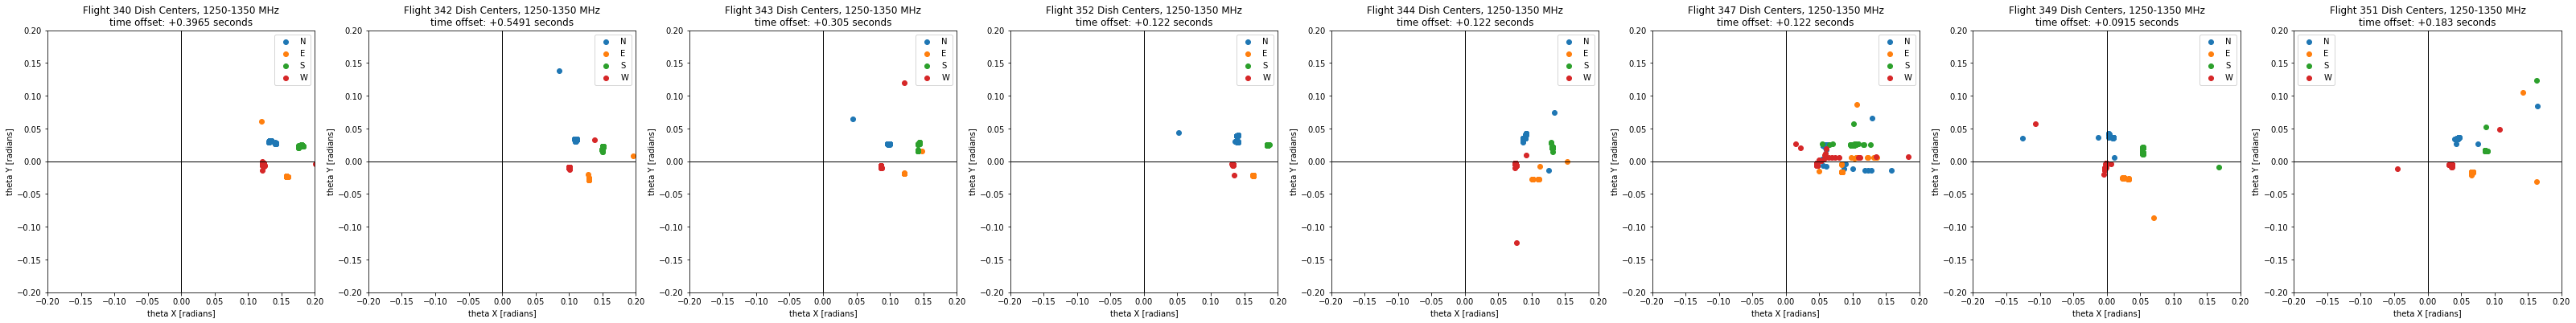

In [342]:
#organizing the gaussfit centers by dish and flight
gauss_sorted = np.empty((len(gauss), len(gauss[0][0]), len(gauss[0])),dtype = object)
gauss_sortedX = np.zeros((len(gauss), len(gauss[0][0]), len(gauss[0])))
gauss_sortedY = np.zeros((len(gauss), len(gauss[0][0]), len(gauss[0])))
for i in range(len(gauss_sorted)):
    for j in range(len(gauss_sorted[i])):
        for k in range(len(gauss_sorted[i][j])):
            gauss_sorted[i][j][k] = gauss[i][k][j]
            gauss_sortedX[i][j][k] = gauss[i][k][j][1]
            gauss_sortedY[i][j][k] = gauss[i][k][j][2]

#plotting the gaussfit centers for each flight between 1250 and 1350 MHz
fig, axs = plt.subplots(nrows = 1, ncols = len(gauss_sorted), figsize = (len(gauss_sorted)*7,6))

for i in range(len(gauss_sorted)):
    for j in range(len(gauss_sorted[i])):
        axs[i].scatter(gauss_sortedX[i][j], gauss_sortedY[i][j], label = dishes[j])

    axs[i].set_xlim(-0.2,0.2)
    axs[i].set_ylim(-.2,.2)
    axs[i].plot([0,0],[-.2,.2], marker = None, linewidth = 1, color = 'black')
    axs[i].plot([-.2,.2],[0,0], marker = None, linewidth = 1, color = 'black')
    axs[i].set_xlabel('theta X [radians]')
    axs[i].set_ylabel('theta Y [radians]')
    axs[i].set_title('Flight ' + flightnames[i] + ' Dish Centers, 1250-1350 MHz\ntime offset: +'+str(np.round(mode[i],4))+' seconds')
    axs[i].legend()
#plt.savefig('dishpointing_optimized.png')

In [470]:
#attempting to fit an airy disk to the data to see if it is a better match
#using roughly the same procedure as the gaussian fits used to create the above sets of graphs
#in lieu of creating an airy disk function, just fitting using the astropy model AiryDisk2D

freqbin_min = 70 #index of 1250 MHz
freqbin_max = 117 #index of 1350 MHz
flight_index = 0 #needed index and flight name, keeping track if index separately

fitter = fitting.LevMarLSQFitter()

#preallocation of guassian fits and errors
airy = np.empty(len(flightnames), dtype = object)

for flight in flightnames:
    airyflight = np.empty((freqbin_max-freqbin_min), dtype = object)
    for freq_index in range(freqbin_min, freqbin_max):
        #getting data
        signal, xdata, ydata = get_data(flight, freq_index)
        #converting back from offset to index
        offset_index = np.int(np.round(mode[flight_index]/conversionfactor))
        
        #preallocating time-sliced signal data
        tempSig = np.empty(4, dtype = object)
        tempX = np.empty(4, dtype = object)
        tempY = np.empty(4, dtype = object)
        #applying time offset by shifting trimming the signal data at the end
        #and the location data at the beginning
        #by the amount specified by the offset index
        for j in range(len(tempSig)):
            tempSig[j] = signal[j][:(len(signal[j])-offset_index)]
            tempX[j] = xdata[j][offset_index:]
            tempY[j] = ydata[j][offset_index:]
        
        #fitting each of the 4 dishes
        airydishes = np.empty(4, dtype = object)
        for i in range(len(tempSig)):
            #setting aside initial guesses for fits
            amp = max(tempSig[i])
            xmean = tempX[i][np.where(tempSig[i] == max(tempSig[i]))]
            ymean = tempY[i][np.where(tempSig[i] == max(tempSig[i]))]  
            initial_guess = models.AiryDisk2D(amp, xmean, ymean, 0.1) 
            #radius variable set to 0.1, based on roughly the edges of previous data visualization
            #sufficient for an initial guess
            airydishes[i] = fitter(initial_guess, tempX[i], tempY[i], tempSig[i])
        
        airyflight[freq_index-freqbin_min] = airydishes
        
    airy[flight_index] = airyflight
    flight_index += 1

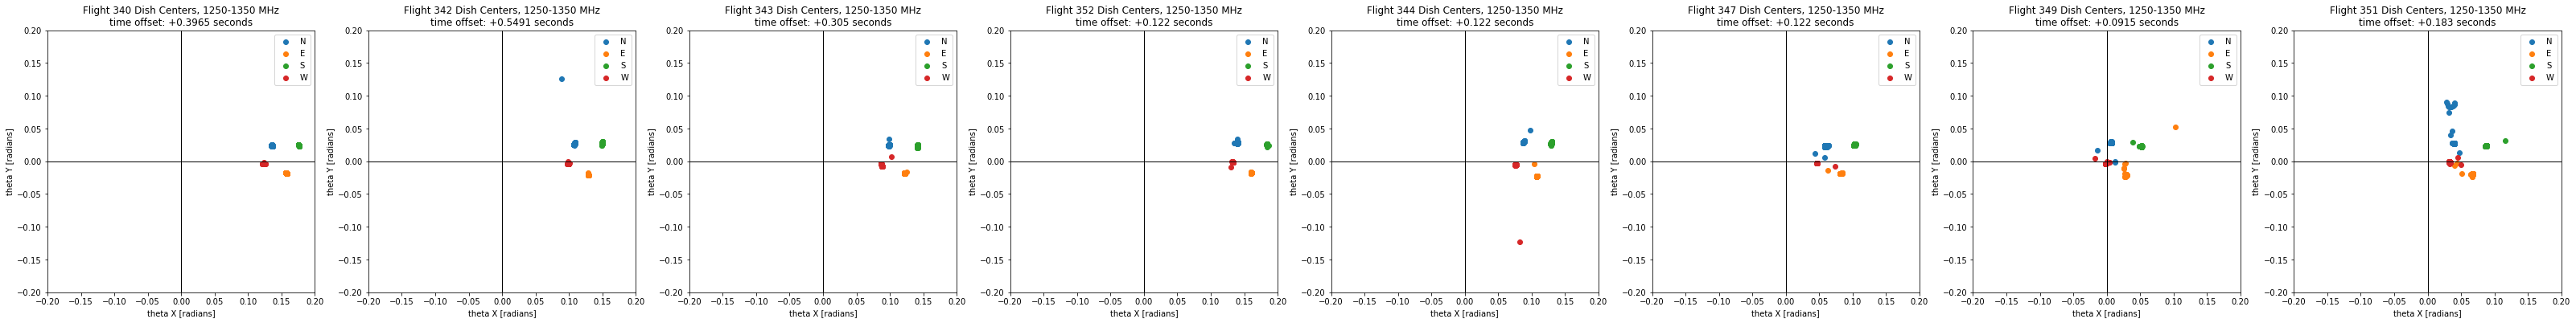

In [480]:
#gotta reorganize the data to plot airy2d fit dish pointings right...
#current hierarchy is flight - frequency - dish
#needs to be flight - dish - frequency

airy_sorted = np.empty((len(airy), len(airy[0][0]), len(airy[0])), dtype = object)
airy_sortedX = np.zeros((len(airy), len(airy[0][0]), len(airy[0])))
airy_sortedY = np.zeros((len(airy), len(airy[0][0]), len(airy[0])))
for i in range(len(airy)):
    for j in range(len(airy[0][0])):
        for k in range(len(airy[0])):
            airy_sorted[i][j][k] = airy[i][k][j]
            airy_sortedX[i][j][k] = airy[i][k][j].x_0.value
            airy_sortedY[i][j][k] = airy[i][k][j].y_0.value


fig, axs = plt.subplots(nrows = 1, ncols = 8, figsize = (56, 6))

for i in range(len(airy_sortedX)):
    for j in range(len(airy_sortedX[i])):
        axs[i].scatter(airy_sortedX[i][j], airy_sortedY[i][j], label = dishes[j])
    
    axs[i].set_xlim(-0.2,0.2)
    axs[i].set_ylim(-.2,.2)
    axs[i].plot([0,0],[-.2,.2], marker = None, linewidth = 1, color = 'black')
    axs[i].plot([-.2,.2],[0,0], marker = None, linewidth = 1, color = 'black')
    axs[i].set_xlabel('theta X [radians]')
    axs[i].set_ylabel('theta Y [radians]')
    axs[i].set_title('Flight ' + flightnames[i] + ' Dish Centers, 1250-1350 MHz\ntime offset: +'+str(np.round(mode[i],4))+' seconds')
    axs[i].legend()
plt.savefig('dishpointing_optimized_airy.png')

In [481]:
#compare residuals across the board between gaussian fits and airy disk fits
#using unshifted data, since that may systematically favor gaussian fits
#since residual metric was optimized using gaussian fits

residual_comparison = Table(names = ('Flight','Dish','Frequency','Gauss_residual','Airy_residual')
                            ,dtype = ['str','str','int','float','float'])

for i in range(len(airy_sorted)): #flight
    
    #converting back from offset to index
    offset_index = np.int(np.round(mode[i]/conversionfactor))
    
    for j in range(len(airy_sorted[i])): #dish
        for k in range(len(airy_sorted[i][j])): #frequency
            #getting data
            signal, xdata, ydata = get_data(flightnames[i], k+freqbin_min)

            #creating astropy models
            airyModel = airy_sorted[i][j][k]
            gaussModel = models.Gaussian2D(gauss_sorted[i][j][k][0],gauss_sorted[i][j][k][1]
                                           ,gauss_sorted[i][j][k][2],gauss_sorted[i][j][k][3]
                                           ,gauss_sorted[i][j][k][4],gauss_sorted[i][j][k][5])
            
            airyResid = np.sum((airyModel(xdata[j], ydata[j]) - signal[j])**2)/len(signal[j])
            gaussResid = np.sum((gaussModel(xdata[j], ydata[j]) - signal[j])**2)/len(signal[j])
            
            freq = np.int(np.round((1100 + (k+freqbin_min)*2.1484375)))
            
            next_row = [flightnames[i],dishes[j],freq,gaussResid,airyResid]
            residual_comparison.add_row(next_row)


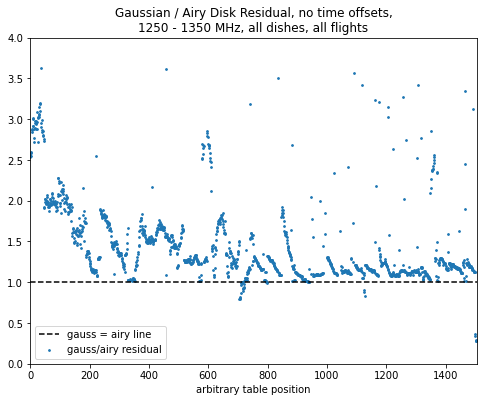

In [482]:
x = np.arange(len(residual_comparison))
fig = plt.figure(figsize = (8,6))
plt.scatter(x,residual_comparison['Gauss_residual']/residual_comparison['Airy_residual'], s = 3, label = 'gauss/airy residual')
plt.ylim(0,4)
plt.xlim(0, len(x))
plt.xlabel('arbitrary table position')
plt.title('Gaussian / Airy Disk Residual, no time offsets,\n1250 - 1350 MHz, all dishes, all flights')
plt.plot([0,len(x)],[1,1], color = 'black', linestyle = '--', label = 'gauss = airy line')
plt.legend()
plt.savefig('gauss_airy_ratios.png')

In [483]:
airy_array = np.zeros((len(airy_sorted),len(airy_sorted[0]),len(airy_sorted[0][0]), 4))
radii = []
for i in range(len(airy_array)):
    for j in range(len(airy_array[i])):
        for k in range(len(airy_array[i][j])):
            airy_array[i][j][k][0] = airy_sorted[i][j][k].amplitude.value
            airy_array[i][j][k][1] = airy_sorted[i][j][k].x_0.value
            airy_array[i][j][k][2] = airy_sorted[i][j][k].y_0.value
            airy_array[i][j][k][3] = airy_sorted[i][j][k].radius.value
            radii.append(airy_sorted[i][j][k].radius.value)

In [406]:
'mean = ' + str(np.round(np.mean(radii),4)) + ', min val = ' + str(np.round(min(radii),4)) + ', max val = ' + str(np.round(max(radii),4)) + ', std = ' + str(np.round(np.std(radii),4))

'mean = 0.1269, min val = -0.0232, max val = 7.5212, std = 0.2416'

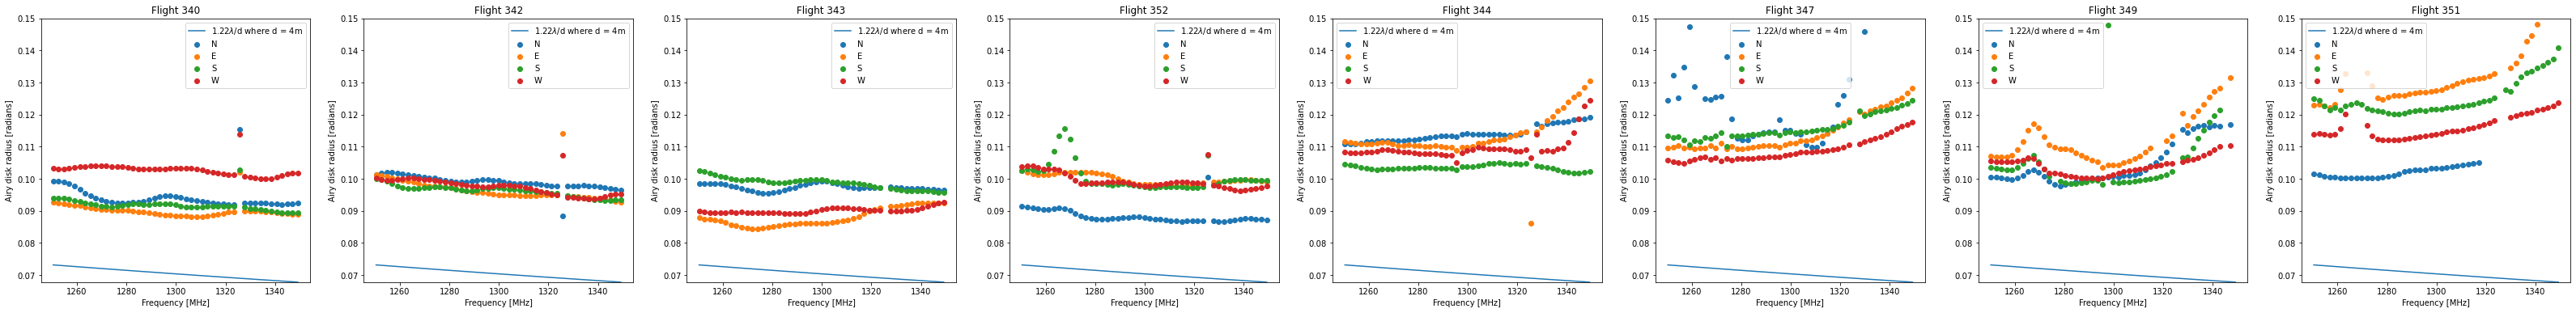

In [484]:
freqs = []
expected_fw = []
dish_diameter = 4
for i in range(len(airy_array[0][0])):
    freqs.append(1100 + (i+freqbin_min)*2.1484375)
    expected_fw.append((1.22 * 3e8) / (freqs[i] * 1e6 * dish_diameter))
    
fig, axs = plt.subplots(nrows = 1, ncols = 8, figsize = (56, 6))
for i in range(len(airy_array)): #flight
    for j in range(len(airy_array[i])): #dish
        axs[i].scatter(freqs,airy_array[i][j][:,3], label = dishes[j])
    axs[i].set_ylim(min(expected_fw), 0.15)
    axs[i].plot(freqs, expected_fw, label = '1.22$\lambda$/d where d = '+str(dish_diameter)+'m')
    axs[i].set_xlabel('Frequency [MHz]')
    axs[i].set_ylabel('Airy disk radius [radians]')
    axs[i].set_title('Flight '+flightnames[i])
    axs[i].legend()
plt.savefig('airyradius_vs_freq_allflights.png')

In [485]:
gauss_array = np.zeros((8,4,47,6))
for i in range(len(gauss_array)):
    for j in range(len(gauss_array[i])):
        for k in range(len(gauss_array[i][j])):
            for l in range(len(gauss_array[i][j][k])):
                gauss_array[i][j][k][l] = gauss_sorted[i][j][k][l]

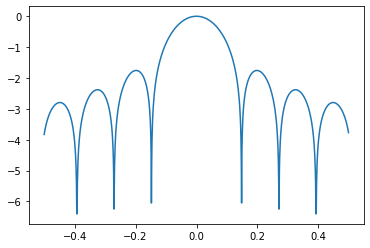

In [546]:
A = airy_array[0][0][0][0] #model amp
R = airy_array[0][0][0][3] #model radius
Rz = 1.2196698912665045 #Rz from astropy.models.AiryDisk2D
r = np.arange(-.5,.5,0.001) #independent variable
x = (np.pi*r)/(R*Rz)

bessel = jv(1, x)

airymodel = A*(2*bessel/x)**2
airymodeldB = np.log10(airymodel/A)
plt.plot(r, airymodeldB)


In [557]:
sig, xdata, ydata = get_data(flightnames[0],freqbin_min)
xdata = xdata - airy_array[0][0][0][1]
ydata = ydata - airy_array[0][0][0][2]

xi = np.linspace(-0.5, 0.5, 1001)
yi = np.linspace(-0.5, 0.5, 1001)

image = interp.griddata((xdata[0], ydata[0]), sig[0], (xi[None,:], yi[:,None]), method = 'linear', fill_value = min(sig[0]))

avgSig = []
rad = []
for i in range(0,495,5):
    sigsum = 0
    npoints = 0
    for j in range(len(image)):
        for k in range(len(image[j])):
            distance = np.sqrt((j-501)**2+(k-501)**2)
            if (distance >= i) and (distance < i+5):
                npoints += 1
                sigsum += image[j][k]

    avgSig.append(sigsum/npoints)
    rad.append((i+2.5)/500.5 * 0.5)

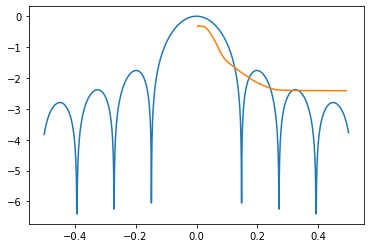

In [558]:
plt.plot(r, airymodeldB)
plt.plot(rad, np.log10(avgSig/A))

5542555578418306.0